In [199]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import GraphHelpers as GH
import ETFunctions as et
import MathsUtilities as MUte

## Bring in the data needed

In [200]:
WheatBiomass = pd.concat([pd.read_excel('./Wheat/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Wheat'],names=['Crop'])
BarleyBiomass = pd.concat([pd.read_excel('./Barley/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Barley'],names=['Crop'])
OatsBiomass = pd.concat([pd.read_excel('./Oats/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['Oats'],names=['Crop'])
FodderBeet = pd.concat([pd.read_excel('./FodderBeet/RawDatafiles/Biomass.xlsx',header=[0,1,2])],axis=1,keys=['FodderBeet'],names=['Crop'])
LucerneAndPasture = pd.read_excel('./LucerneAndPasture/RawDatafiles/Biomass.xlsx',header=[0,1,2])
SpecLab = LucerneAndPasture.columns.get_level_values(0)
IrriLab = LucerneAndPasture.columns.get_level_values(1)
BlocLab = LucerneAndPasture.columns.get_level_values(2)
NewCols = pd.MultiIndex.from_arrays([SpecLab,
                                     SpecLab,
                                     IrriLab,
                                     SpecLab,
                                     BlocLab], names=['Species','Crop','Irrigation','Nitrogen','Block'])
LucerneAndPasture.columns = NewCols
RyegrassBiomass = LucerneAndPasture.Ryegrass.copy().cumsum()
LucerneBiomass = LucerneAndPasture.Lucerne.copy().cumsum()
Biomass = pd.concat([WheatBiomass,BarleyBiomass,OatsBiomass,FodderBeet,LucerneBiomass,RyegrassBiomass],axis=1)

In [201]:
MetData = pd.read_pickle('BroadFieldsMet.pkl')
DaylightIndex = MetData.IncomingRadnMJ.where(MetData.IncomingRadnMJ>0.002)
DaylightIndex.dropna(inplace=True)
DaylightIndex = DaylightIndex.index.tolist()
MetData.loc[:,'satVP'] = [et.saturated_vapor_pressure(MetData.loc[x,'AirTemperature'])/10 for x in MetData.index]
MetData.loc[:,'VP'] = [MetData.loc[x,'satVP']*MetData.loc[x,'RelativeHumidity']/100 for x in MetData.index]
MetData.loc[:,'VPD'] = MetData.satVP.subtract(MetData.VP)

DailyMet = MetData.IncomingRadnMJ.resample('D').sum()
DailyMet = pd.DataFrame(index=DailyMet.index,data=DailyMet.values,columns=['Radn'])
DailyMet.loc[:,'Temp'] = MetData.AirTemperature.resample('D').mean()
DailyMet.loc[:,'RH'] = MetData.RelativeHumidity.resample('D').mean()
DailyMet.loc[:,'PET'] = [et.Priestly_TaylorEO(DailyMet.loc[x,'Radn'],
                                    DailyMet.loc[x,'Temp'],
                                    1.3,'Total') for x in DailyMet.index]
DailyMet.loc[:,'VPD'] = MetData.loc[DaylightIndex,'VPD'].resample('D').mean()
MinVPD = 0.1
DailyMet.loc[:,'VPD'] = DailyMet.loc[:,'VPD'].where(DailyMet.loc[:,'VPD']>MinVPD,MinVPD)
AccumPET = DailyMet.PET.cumsum()

In [202]:
#Bring in soil water use data.
LucWU = pd.read_pickle('.\LucerneAndPasture\DataFrames\LucWU.pkl').cumsum()
RyeWU = pd.read_pickle('.\LucerneAndPasture\DataFrames\RyeWU.pkl').cumsum()
LucWU = LucWU.where(LucWU.notna(),0)
RyeWU = RyeWU.where(RyeWU.notna(),0)

In [203]:
StartDate = LucWU.index.min()
EndDate = LucWU.index.max()
AllDays = AccumPET.loc[StartDate:EndDate].index
LucWUDaily = pd.DataFrame(index = AllDays,columns = LucWU.columns)
RyeWUDaily = pd.DataFrame(index = AllDays,columns = RyeWU.columns)
LucWU.loc[:,'AccumPET'] = [AccumPET[x] for x in LucWU.index]
RyeWU.loc[:,'AccumPET'] = [AccumPET[x] for x in RyeWU.index]
for col in LucWUDaily.columns:
    LucWUDaily.loc[:,col] = np.interp(AccumPET.loc[AllDays].values,
                                      LucWU.AccumPET,
                                      pd.to_numeric(LucWU.loc[:,col]))
for col in RyeWUDaily.columns:
    RyeWUDaily.loc[:,col] = np.interp(AccumPET.loc[AllDays].values,
                                      RyeWU.AccumPET,
                                      pd.to_numeric(RyeWU.loc[:,col]))

In [204]:
LucWU = -LucWUDaily.diff()
RyeWU = -RyeWUDaily.diff()

WheatDaylightIndex = np.load('.\Wheat\DataFrames\DaylightIndex.npy')
WheatHourlyWU = pd.read_pickle('.\Wheat\DataFrames\HourlyWUmm.pkl')
WheatWU = pd.concat([WheatHourlyWU.reindex(WheatDaylightIndex).resample('d').sum()],axis=1,keys=['Wheat'],names=['Crop'])

FodderBeetDaylightIndex = np.load('.\FodderBeet\DataFrames\DaylightIndex.npy')
FodderBeetHourlyWU = pd.read_pickle('.\FodderBeet\DataFrames\HourlyWUmm.pkl')
FodderBeetWU = pd.concat([FodderBeetHourlyWU.reindex(FodderBeetDaylightIndex).resample('d').sum()],axis=1,keys=['FodderBeet'],names=['Crop'])

OatsDaylightIndex = np.load('.\Oats\DataFrames\DaylightIndex.npy')
OatsHourlyWU = pd.read_pickle('.\Oats\DataFrames\HourlyWUmm.pkl')
OatsWU = pd.concat([OatsHourlyWU.reindex(OatsDaylightIndex).resample('d').sum()],axis=1,keys=['Oats'],names=['Crop'])
#OatsWU = pd.concat([pd.read_pickle('.\Oats\DataFrames\DailyWU.pkl')],axis=1,keys=['Oats'],names=['Crop'])

BarleyDaylightIndex = np.load('.\Barley\DataFrames\DaylightIndex.npy')
BarleyHourlyWU = pd.read_pickle('.\Barley\DataFrames\HourlyWUmm.pkl') 
BarleyWU = pd.concat([BarleyHourlyWU.reindex(BarleyDaylightIndex).resample('d').sum()],axis=1,keys=['Barley'],names=['Crop'])
#BarleyWU.columns = BarleyWU.columns.swaplevel('Irrigation','Cultivar')

WU = pd.concat([WheatWU,FodderBeetWU,LucWU,RyeWU,OatsWU,BarleyWU],axis=1)
WU.dropna(how='all',inplace=True)
GH.SortFrame(WU)

In [205]:
CommonDates = list(set(Biomass.index).intersection(WU.index))
CommonDates.sort()

In [206]:
WU = WU.loc[np.min(CommonDates):,:].dropna(how='all').copy()
AccumulatedWU = -WU.cumsum(axis=0).copy()
WUoverVPD = WU.divide(DailyMet.loc[WU.index,'VPD'],axis=0)
AccumWUoverVPD = -WUoverVPD.cumsum(axis=0).copy()

In [207]:
SetDate1 = '2012-07-01'
SetDate2 = '2013-07-01'
StartDate2 = '2013-07-02'
FinalDate = '2014-07-01'
AccumSet1 = AccumulatedWU.loc[SetDate1,:].copy()
AccumSet2 = AccumulatedWU.loc[SetDate2,:].copy()
AccumulatedWU.loc[SetDate1:SetDate2,'Lucerne'] = AccumulatedWU.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
AccumulatedWU.loc[StartDate2:FinalDate,'Lucerne'] = AccumulatedWU.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
AccumulatedWU.loc[SetDate1:SetDate2,'Ryegrass'] = AccumulatedWU.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
AccumulatedWU.loc[StartDate2:FinalDate,'Ryegrass'] = AccumulatedWU.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values

AccumSet1 = AccumWUoverVPD.loc[SetDate1,:].copy()
AccumSet2 = AccumWUoverVPD.loc[SetDate2,:].copy()
AccumWUoverVPD.loc[SetDate1:SetDate2,'Lucerne'] = AccumWUoverVPD.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
AccumWUoverVPD.loc[StartDate2:FinalDate,'Lucerne'] = AccumWUoverVPD.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
AccumWUoverVPD.loc[SetDate1:SetDate2,'Ryegrass'] = AccumWUoverVPD.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
AccumWUoverVPD.loc[StartDate2:FinalDate,'Ryegrass'] = AccumWUoverVPD.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values

AccumSet1 = Biomass.loc[SetDate1,:].copy()
AccumSet2 = Biomass.loc[SetDate2,:].copy()
Biomass.loc[SetDate1:SetDate2,'Lucerne'] = Biomass.loc[SetDate1:SetDate2,'Lucerne'].subtract(AccumSet1.Lucerne,axis=1).values
Biomass.loc[StartDate2:FinalDate,'Lucerne'] = Biomass.loc[StartDate2:FinalDate,'Lucerne'].subtract(AccumSet2.Lucerne,axis=1).values
Biomass.loc[SetDate1:SetDate2,'Ryegrass'] = Biomass.loc[SetDate1:SetDate2,'Ryegrass'].subtract(AccumSet1.Ryegrass,axis=1).values
Biomass.loc[StartDate2:FinalDate,'Ryegrass'] = Biomass.loc[StartDate2:FinalDate,'Ryegrass'].subtract(AccumSet2.Ryegrass,axis=1).values


In [208]:
Crops = Biomass.columns.get_level_values(0).drop_duplicates().values
WheatGPs = GH.SetGraphicsPatterns(Biomass.Wheat.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

FodderBeetGPs = GH.SetGraphicsPatterns(Biomass.FodderBeet.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

LucerneGPs = GH.SetGraphicsPatterns(Biomass.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)

RyegrassGPs = GH.SetGraphicsPatterns(Biomass.loc[:,['Lucerne','Ryegrass']].columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['red','blue','green','orange'],InvertLevels=True)

OatsGPs = GH.SetGraphicsPatterns(Biomass.Oats.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['purple','green','orange'])
BarleyGPs = GH.SetGraphicsPatterns(Biomass.Barley.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '50', '250']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '250', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 2, 1, 0, 2, 1]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
              Lin     Col   Alp Mar     MFC
Dryland   0     -  orange  0.15   o  orange
          50    -   green  0.15   o   green
          250   -  purple  0.15   o  purple
Irrigated 0    --  orange  0.45   ^   white
          50   --   green  0.45   ^   white
          250  --  purple  0.45   ^   white
Irrigation
['Dryland', 'Irrigated']
Nitrogen
['0', '50', '300']
Treatments
MultiIndex(levels=[['Dryland', 'Irrigated'], ['0', '300', '50']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 2, 1, 0, 2, 1]])
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'ora

In [209]:
def MakeTimeSeriesGraphs(Data,name,ymin,ymax=None):
    Graph = plt.figure(figsize=(18,30))
    Crops = Data.columns.get_level_values(0).drop_duplicates().values
    pos = 1
    for C in Crops:
        GP = globals()[C+'GPs']
        ax = Graph.add_subplot(3,2,pos)
        plt.title(C, fontsize=28)
        GH.AddIndexedPlot(Data.reindex(CommonDates).loc[:,C].dropna(how='all'),ax,GP,2)
        plt.ylabel(name, fontsize=36);
        plt.ylim(ymin,ymax)
        plt.tick_params(labelsize=20)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=int(np.ceil(Data.loc[:,C].dropna(how='all').index.size/30/5))))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
        GH.AddLegend(1,16,'')
        pos+=1
def MakeSingleCropTimeSeries(Data,Crop):
    graph = plt.figure(figsize=(18,18))
    ax = graph.add_subplot(1,1,1)
    GP = globals()[Crop+'GPs']
    GH.AddIndexedPlot(Data.reindex(CommonDates).loc[:,Crop].dropna(how='all'),ax,GP,2)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


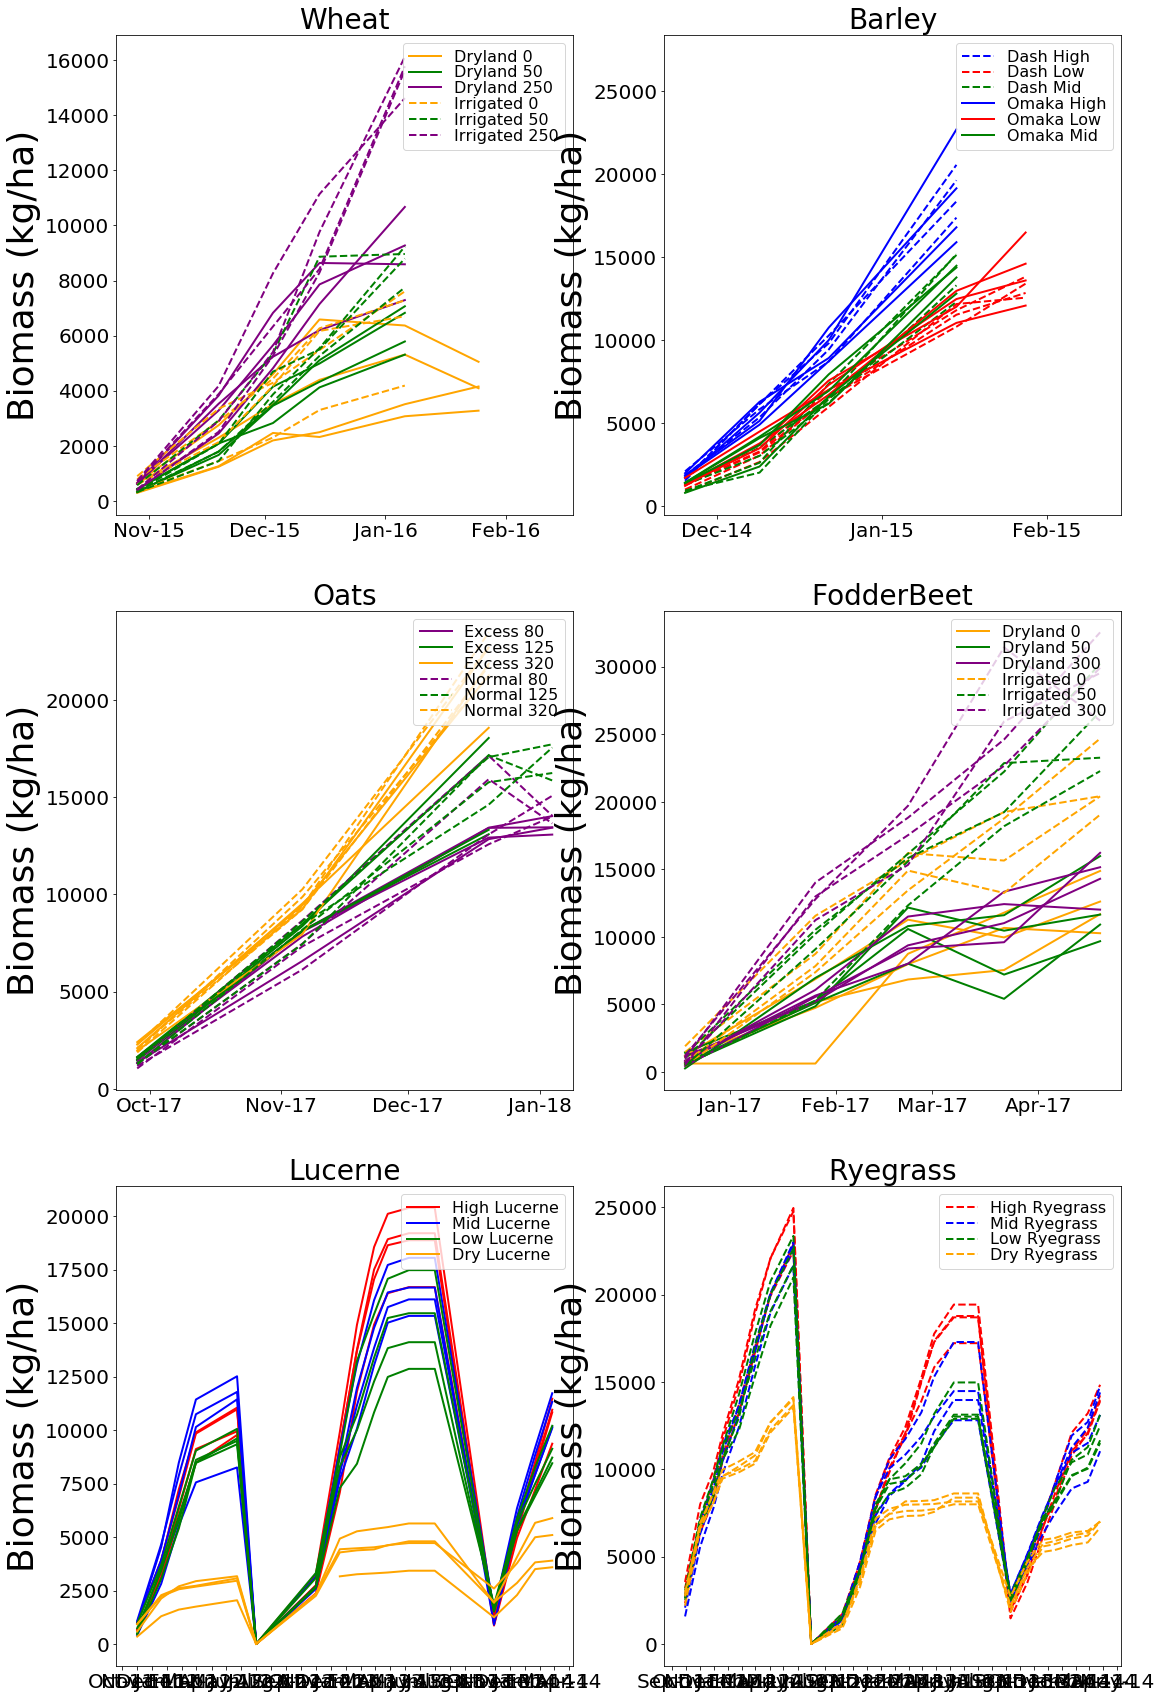

In [210]:
MakeTimeSeriesGraphs(Biomass,'Biomass (kg/ha)',None,)

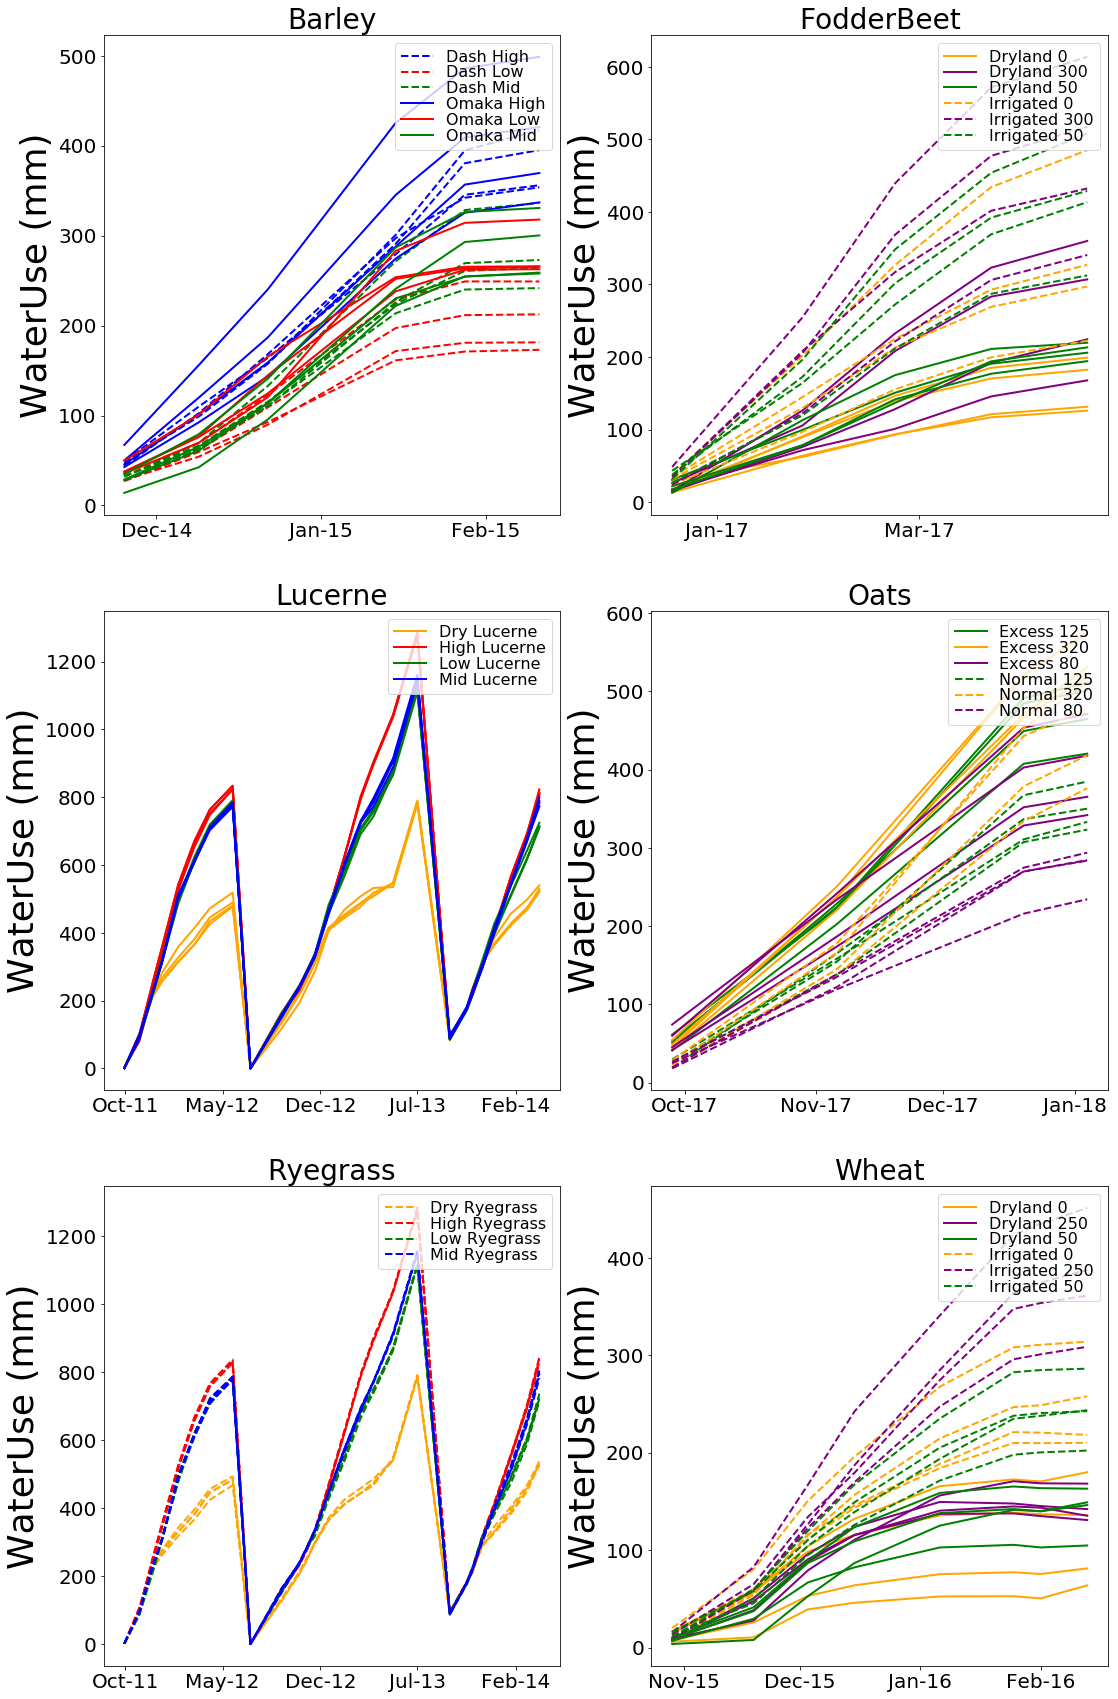

In [211]:
MakeTimeSeriesGraphs(AccumulatedWU,'WaterUse (mm)',None,)

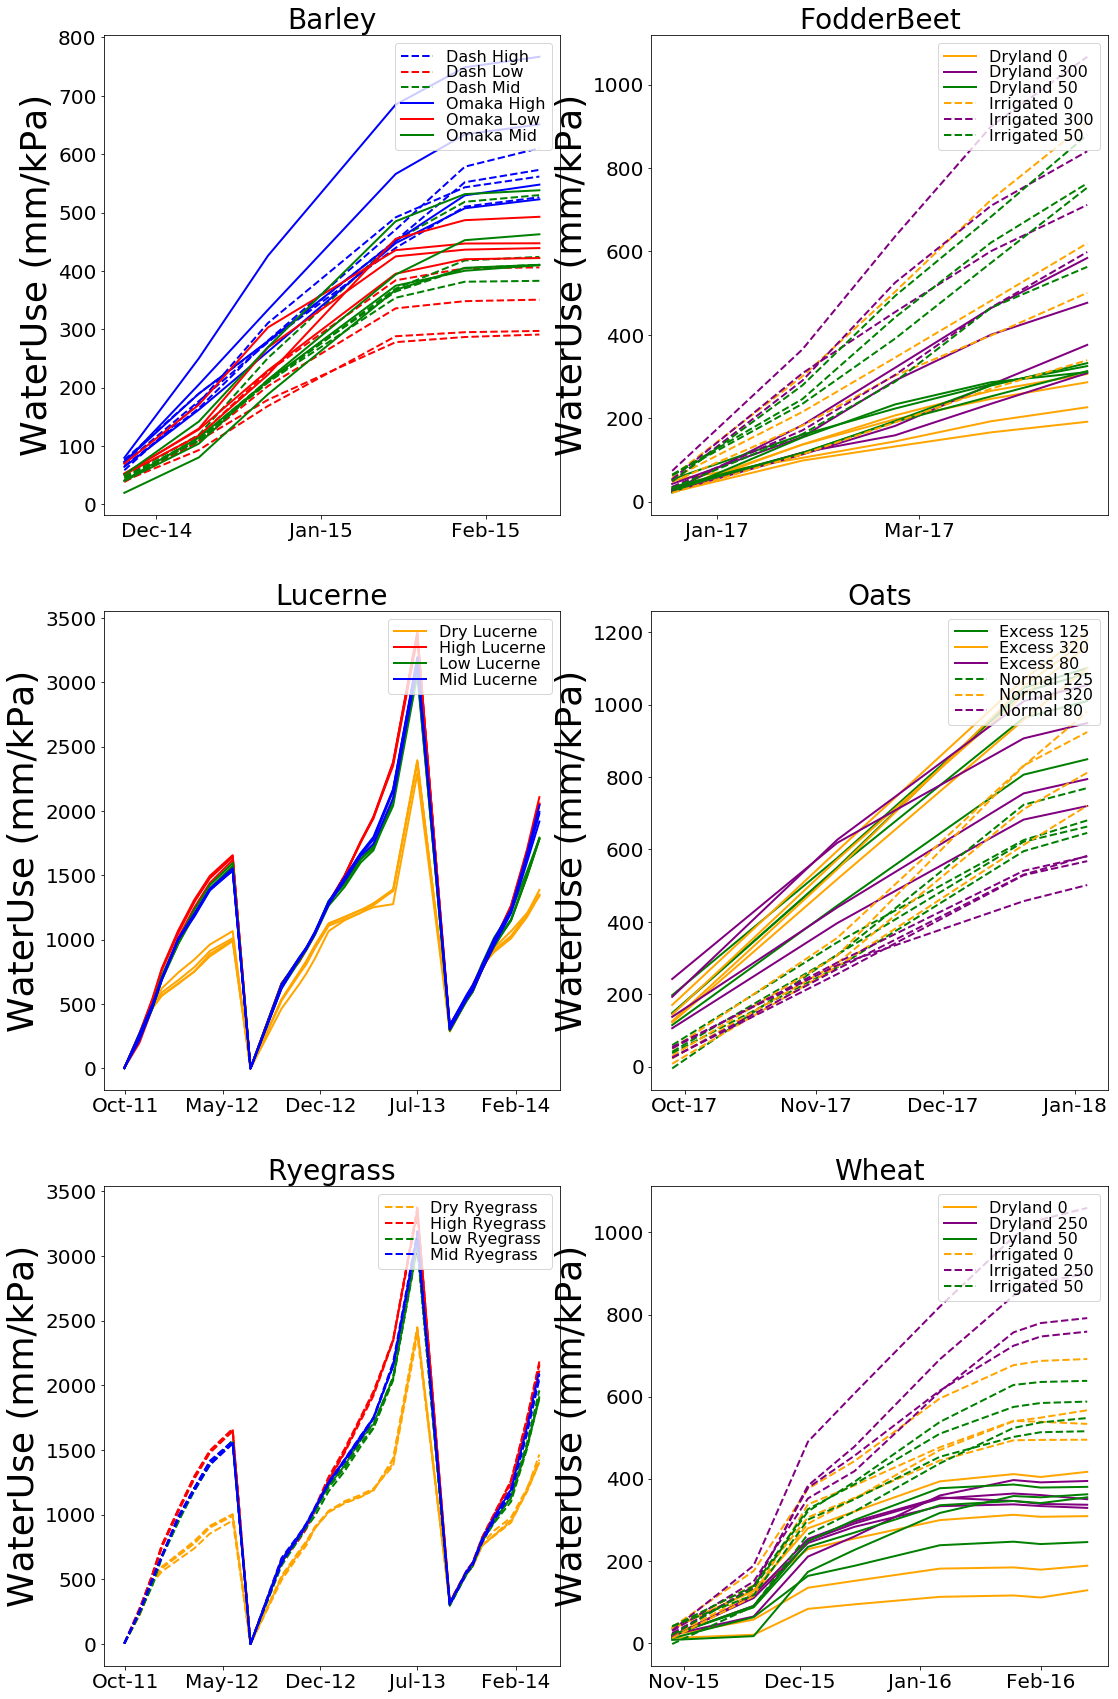

In [212]:
MakeTimeSeriesGraphs(AccumWUoverVPD,'WaterUse (mm/kPa)',None,)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


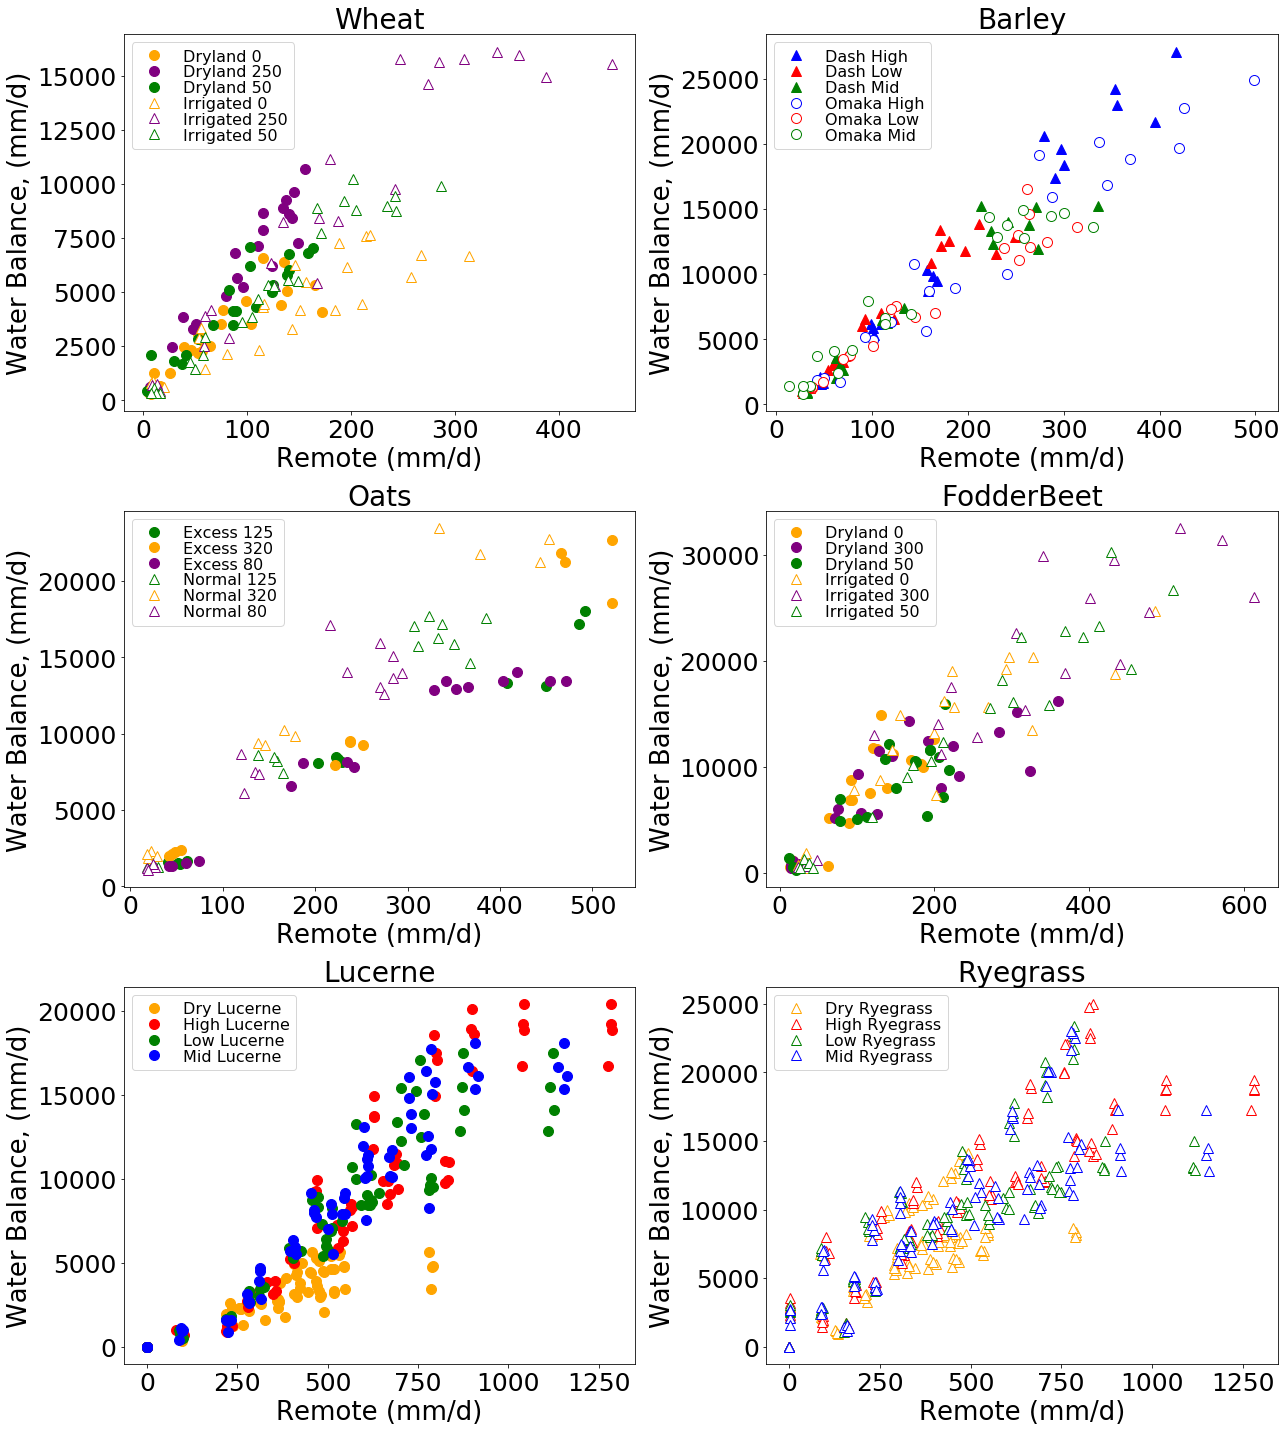

In [213]:
Graph = plt.figure(figsize=(18,20))
pos =  1
for crop in Crops:
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedXY(AccumulatedWU.reindex(Biomass.index).loc[:,crop],
                        Biomass.loc[:,crop],
                        ax,globals()[crop+'GPs'], 10)
        GH.SetAxProps(crop,30,'Water Balance, (mm/d)','Remote (mm/d)',26,25)
        GH.AddLegend(2,16,"")
        plt.title(crop, fontsize=28)
#         Y = MeanPeriodE.loc[:,crop].stack().stack().stack()
#         X = -1 * WU.loc[:,crop].stack().stack().stack().reindex(Y.index)
#         RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
#         Xs = []
#         Xs.append(X.min())
#         Xs.append(X.max())
#         Ys = []
#         Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
#         Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#         plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
#         fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#             + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
#             + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
#             + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
#         plt.text(.7,.05,fitR2,fontsize=16,transform=ax.transAxes)
        pos +=1
plt.tight_layout()   

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


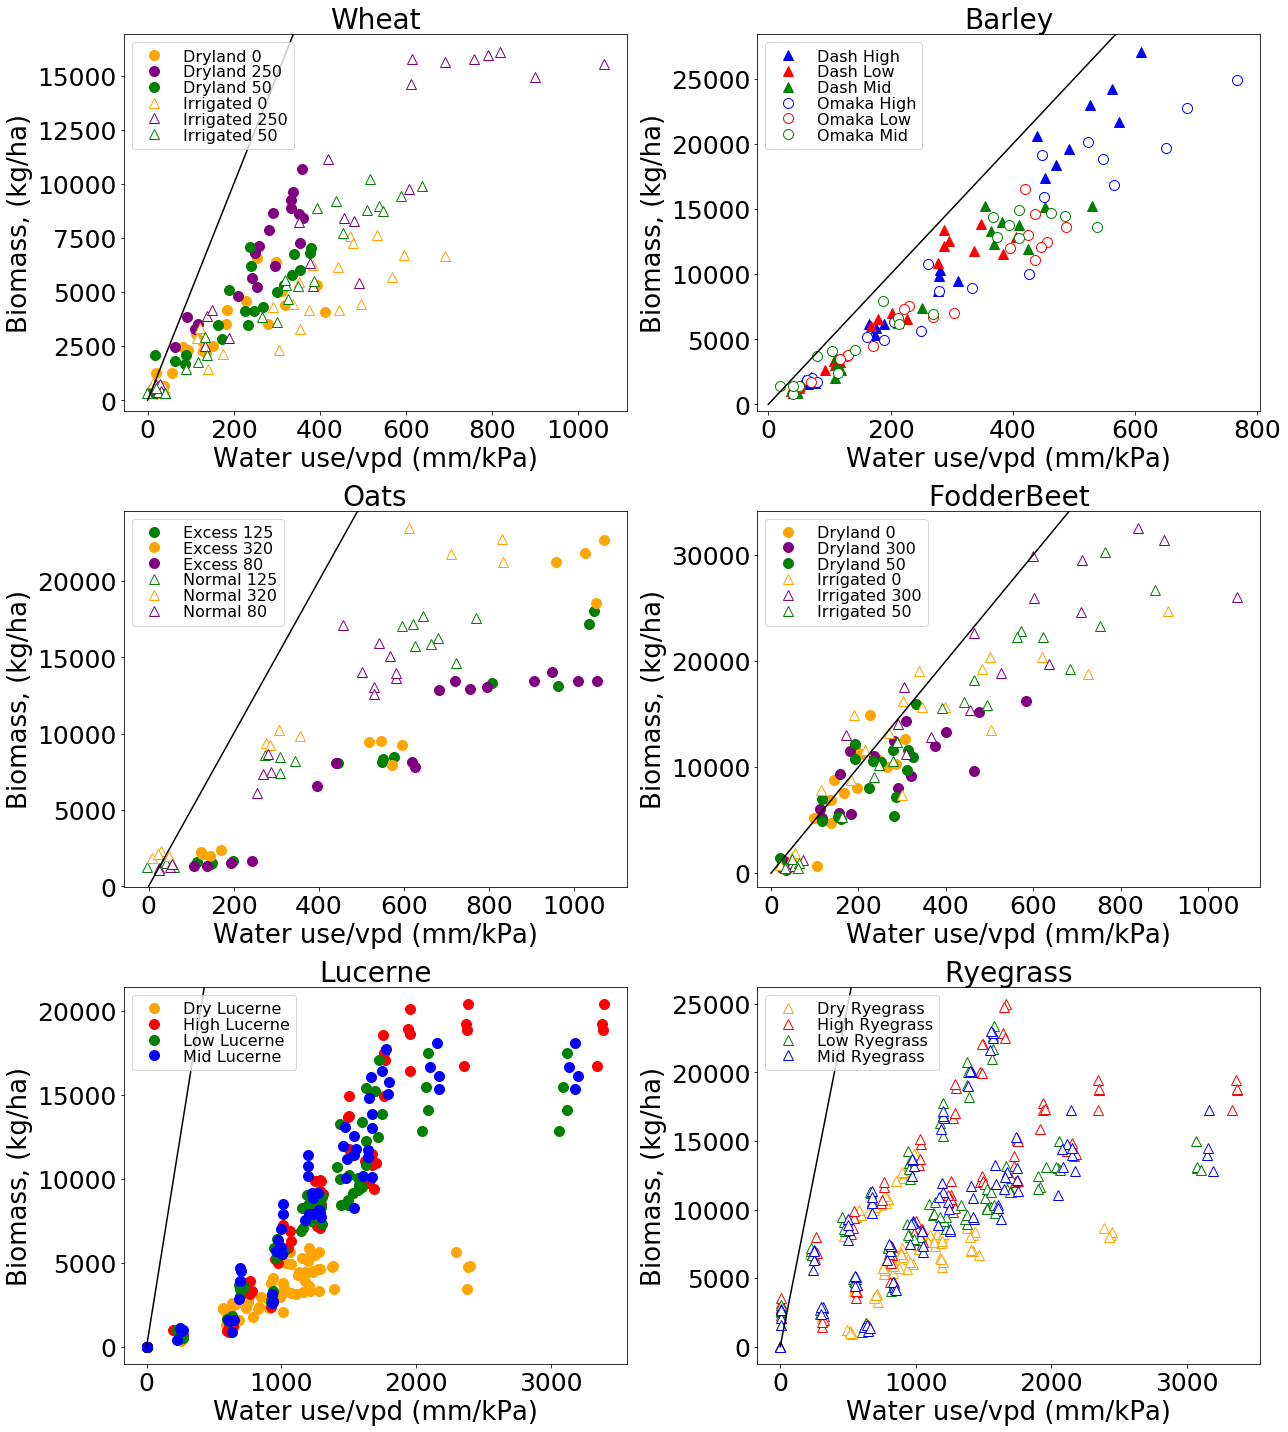

In [219]:
Graph = plt.figure(figsize=(18,20))
pos =  1
for crop in Crops:
        ax = Graph.add_subplot(3,2,pos)
        GH.AddIndexedXY(AccumWUoverVPD.reindex(Biomass.index).loc[:,crop],
                        Biomass.loc[:,crop],
                        ax,globals()[crop+'GPs'], 10)
        GH.SetAxProps(crop,30,'Biomass, (kg/ha)','Water use/vpd (mm/kPa)',26,25)
        GH.AddLegend(2,16,"")
        plt.title(crop, fontsize=28)
        plt.plot([0,1500],[0,75000],'-k')
#         Y = MeanPeriodE.loc[:,crop].stack().stack().stack()
#         X = -1 * WU.loc[:,crop].stack().stack().stack().reindex(Y.index)
#         RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
#         Xs = []
#         Xs.append(X.min())
#         Xs.append(X.max())
#         Ys = []
#         Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
#         Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#         plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
#         fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#             + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
#             + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
#             + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
#         plt.text(.7,.05,fitR2,fontsize=16,transform=ax.transAxes)
        pos +=1
plt.tight_layout()   

In [215]:
AccumWUoverVPD.Oats.dropna()

Irrigation       Excess                                                     \
Nitrogen            125                                                320   
Block                 1            2           3            4            1   
2017-09-06    -0.118086    -0.246119   -0.337571    -0.191248    -0.145522   
2017-09-07     1.317410     1.252424    1.669413     2.655680     1.436406   
2017-09-08     3.227119     2.083825    2.813937     4.009645     2.191080   
2017-09-09     4.586211     3.969412    4.729936     5.574647     3.329779   
2017-09-10    14.599221    13.383886   18.156656    12.679330    15.515784   
2017-09-11    23.754448    30.351822   20.412832    47.249168    16.727779   
2017-09-12    49.560065    42.337614   28.859716    54.791951    31.245053   
2017-09-13    65.881328    63.777043   50.046567    82.149035    72.023107   
2017-09-14    78.330167    77.275784   61.225322    90.478056    78.402310   
2017-09-15    81.313413    80.513174   62.941263    93.311530    80.268023   
2017-09-16    87.435522    89.479101   68.036437    99.710121    85.560684   
2017-09-17    89.760434    94.743436   71.299747   102.869164    88.087474   
2017-09-18    68.335434    76.718436   44.424747   108.694164    52.787474   
2017-09-19    87.980881    85.943436   62.420193   127.777110    77.207920   
2017-09-20    99.829166   103.083139   72.110069   148.881549    89.790983   
2017-09-21   111.505675   115.253442   79.989719   154.500034    95.529939   
2017-09-22   116.206237   113.306081   83.061968   166.338237    93.521364   
2017-09-23   122.499135   119.144147   88.900034   172.176302    99.672127   
2017-09-24   126.734232   123.014866   92.726317   176.011473   103.818351   
2017-09-25   129.994407   125.817772   95.276521   178.916662   106.753624   
2017-09-26   132.030270   128.584495   97.985922   181.153153   109.205074   
2017-09-27   137.630144   134.959468  104.010850   186.102943   115.104986   
2017-09-28   148.450120   146.353507  114.999668   197.665824   125.722352   
2017-09-29   152.407586   150.646489  119.095716   201.623290   130.197680   
2017-09-30   156.984598   156.742413  126.629543   207.050892   135.888561   
2017-10-01   164.263655   164.885450  136.536541   216.129909   145.975555   
2017-10-02   168.482555   170.003979  142.726849   220.465427   152.637890   
2017-10-03   172.495977   174.155009  147.631107   224.993072   157.744940   
2017-10-04   176.547895   178.477570  151.935003   229.147648   163.355385   
2017-10-05   182.622336   185.212961  160.936507   236.543988   171.821834   
...                 ...          ...         ...          ...          ...   
2017-12-06   826.989912   901.564436  678.467741   930.613920   858.282345   
2017-12-07   847.760473   934.539536  689.999784   944.506083   865.515389   
2017-12-08   851.720894   939.683721  695.796936   949.917774   871.127183   
2017-12-09   855.419804   944.071738  700.780003   954.493904   878.146859   
2017-12-10   859.357416   948.504685  705.938047   959.371457   885.878551   
2017-12-11   863.827703   953.058912  711.568904   964.356337   893.500260   
2017-12-12   873.760222   963.210531  722.966652   973.695461   903.797945   
2017-12-13   925.409067  1006.022648  774.455277  1006.253523   962.003469   
2017-12-14   930.625588  1012.411439  779.584502  1013.191035   971.784359   
2017-12-15   934.312572  1016.462211  783.264556  1016.777544   977.252175   
2017-12-16   939.345576  1020.446377  786.745422  1020.252998   984.969448   
2017-12-17   941.866721  1023.211045  790.096469  1023.235555   990.297520   
2017-12-18   945.429906  1025.879733  792.496808  1026.601951   996.263919   
2017-12-19   947.162562  1027.772597  794.471698  1028.319227  1002.200429   
2017-12-20   963.370467  1046.242070  806.784680  1035.105298  1051.075428   
2017-12-21   975.365635  1061.162239  821.554849  1052.837967  1089.358097   
2017-12-22   978.607037  1064.627310  825.184730  1056.255950  1099.980602   
2017-12-23   981.35540

In [216]:
AccumulatedWU.Lucerne

Irrigation        Dry                                        High             \
Nitrogen      Lucerne                                     Lucerne              
Block               1          2          3          4          1          2   
2011-09-29   0.728478   0.784398   1.413359   0.916164   1.168237   1.251006   
2011-09-30   1.819281   1.958935   3.529686   2.288004   2.917525   3.124229   
2011-10-01   2.584176   2.782546   5.013699   3.249968   4.144163   4.437773   
2011-10-02   3.328357   3.583854   6.457527   4.185882   5.337585   5.715748   
2011-10-03   3.656771   3.937478   7.094700   4.598908   5.864252   6.279728   
2011-10-04   3.853384   4.149183   7.476159   4.846177   6.179554   6.617369   
2011-10-05   4.375304   4.711168   8.488765   5.502566   7.016541   7.513657   
2011-10-06   5.032687   5.419014   9.764189   6.329318   8.070766   8.642572   
2011-10-07   7.738567   7.885708  12.597919   8.800565  10.952910   9.852539   
2011-10-08  10.722765  10.606119  15.723116  11.525997  14.131501  11.186958   
2011-10-09  15.426612  14.894172  20.649215  15.821964  19.141762  13.290339   
2011-10-10  19.677212  18.769041  25.100651  19.703986  23.669250  15.191045   
2011-10-11  21.649617  20.567096  27.166250  21.505359  25.770139  16.073029   
2011-10-12  26.369247  24.869535  32.108877  25.815739  30.797210  18.183468   
2011-10-13  30.943709  29.039639  36.899477  29.993540  35.669657  20.228992   
2011-10-14  32.486474  30.446033  38.515136  31.402529  37.312920  20.918858   
2011-10-15  35.936302  33.590914  42.127964  34.553215  40.987472  22.461489   
2011-10-16  39.772983  37.088453  46.145924  38.057209  45.074078  24.177107   
2011-10-17  45.410086  42.227266  52.049374  43.205507  51.078388  26.697804   
2011-10-18  47.890149  44.488105  54.646617  45.470519  53.720005  27.806794   
2011-10-19  48.561608  45.100210  55.349802  46.083754  54.435203  28.107045   
2011-10-20  51.951080  48.190071  58.899423  49.179318  58.045469  29.622687   
2011-10-21  54.156705  50.412181  60.800919  51.364123  60.251715  32.158227   
2011-10-22  57.170043  53.448041  63.398756  54.349019  63.265902  35.622297   
2011-10-23  61.264014  57.572611  66.928220  58.404347  67.361027  40.328640   
2011-10-24  65.745949  62.088044  70.792153  62.843976  71.844224  45.480978   
2011-10-25  68.578802  64.942070  73.234391  65.650090  74.677875  48.737566   
2011-10-26  70.406581  66.783511  74.810143  67.460617  76.506170  50.838743   
2011-10-27  74.235723  70.641271  78.111294  71.253615  80.336390  55.240643   
2011-10-28  78.893712  75.334075  82.127005  75.867637  84.995692  60.595370   
...               ...        ...        ...        ...        ...        ...   
2017-12-06        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-07        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-08        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-09        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-10        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-11        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-12        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-13        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-14        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-15        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-16        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-17        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-18        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-19        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-20        NaN        NaN        NaN        NaN        NaN        NaN   
2017-12-21        NaN        NaN        NaN        NaN        NaN        NaN   
